In [11]:
# Veri işleme ve analiz kütüphaneleri
import pandas as pd  # Veri okuma, düzenleme ve veri çerçevesi işlemleri
import numpy as np   # Sayısal hesaplamalar ve dizi işlemleri

# Veri görselleştirme kütüphaneleri
import seaborn as sns  # İstatistiksel veri görselleştirme
import matplotlib.pyplot as plt  # Grafik çizimi
import time  # İşlem sürelerini ölçmek için

# Makine öğrenmesi modelleri
from sklearn.ensemble import RandomForestClassifier  # Rastgele Orman sınıflandırıcısı
from sklearn.linear_model import LogisticRegression  # Lojistik Regresyon sınıflandırıcısı
from sklearn.tree import DecisionTreeClassifier       # Karar Ağacı sınıflandırıcısı
from sklearn.naive_bayes import GaussianNB            # Gaussian Naive Bayes sınıflandırıcısı

# Ön işleme ve özellik seçimi
from sklearn.preprocessing import LabelEncoder       # Kategorik veriyi sayısala çevirme
from sklearn.preprocessing import StandardScaler      # Veriyi ölçeklendirme
from sklearn.feature_selection import RFE             # Recursive Feature Elimination ile özellik seçimi

# Kümeleme
from sklearn.cluster import KMeans  # K-Means kümeleme algoritması

# Model değerlendirme metrikleri
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, roc_auc_score

# Veri setini eğitim ve test olarak ayırma
from sklearn.model_selection import train_test_split

UNSW-NB15 veri seti, ağ trafiği bağlantılarını ve her bağlantının paket, byte ve gecikme gibi özelliklerini içermektedir. Eğitim ve test setlerinde normal ve saldırı bağlantıları yer almakta, attack_cat ve label sütunları ile saldırı türleri ve sınıflar belirtilmiştir. Veri seti hem sayısal hem kategorik özellikler içerdiği için ağ saldırısı tespiti ve sınıflandırma çalışmaları için uygundur

In [13]:
# Eğitim ve test veri setlerini okuma
df_train = pd.read_csv(r"C:\Users\sulen\OneDrive\Masaüstü\Python ile Veri Analizi Atölyesi\UNSW_NB15_training-set.csv")  # Eğitim veri seti
df_test = pd.read_csv(r"C:\Users\sulen\OneDrive\Masaüstü\Python ile Veri Analizi Atölyesi\UNSW_NB15_testing-set.csv")   # Test veri seti

# Veri setlerinin boyutlarını ekrana yazdırma
print("Lenght of training set:", len(df_train))  # Eğitim setinde toplam 82.332 örnek var
print("Lenght of testing set:", len(df_test))    # Test setinde toplam 175.341 örnek var

Lenght of training set: 82332
Lenght of testing set: 175341


Test setinin eğitim setinden daha büyük olması, modelin farklı ve geniş bir örneklem üzerinde sınanmasını sağlar ve sınıflandırma performansının daha güvenilir bir şekilde ölçülmesine olanak tanır.

In [14]:
# Eğitim ve test setleri arasındaki dengeyi sağlamak ve veri üzerinde tekrar tekrar işlem yapmamak için
# Eğitim ve test veri setlerini tek bir veri çerçevesinde birleştiriyoruz
df = pd.concat([df_train, df_test])

# Birleştirilmiş veri setinin yapısını inceleme: sütunlar, veri tipleri ve eksik değerler hakkında bilgi
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 257673 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 257673 non-null  int64  
 1   dur                257673 non-null  float64
 2   proto              257673 non-null  object 
 3   service            257673 non-null  object 
 4   state              257673 non-null  object 
 5   spkts              257673 non-null  int64  
 6   dpkts              257673 non-null  int64  
 7   sbytes             257673 non-null  int64  
 8   dbytes             257673 non-null  int64  
 9   rate               257673 non-null  float64
 10  sttl               257673 non-null  int64  
 11  dttl               257673 non-null  int64  
 12  sload              257673 non-null  float64
 13  dload              257673 non-null  float64
 14  sloss              257673 non-null  int64  
 15  dloss              257673 non-null  int64  
 16  sinpkt 

Birleştirilmiş veri seti 257.673 kayıt ve 45 sütun içermektedir. Çoğu sütun sayısal verilerden oluşurken, yalnızca birkaç sütun metin bilgisi taşımaktadır (proto, service, state ve attack_cat). Tüm veriler eksiksiz olduğu için temizleme ihtiyacı yoktur. Bu durum, veri setinin hem yeterli büyüklükte hem de eksiksiz olduğunu, dolayısıyla ağ trafiği ve saldırı analizi için sağlam ve güvenilir bir temel sağladığını göstermektedir.

In [15]:
# Tüm sütunlar için istatistiksel özet (sayısal ve kategorik) çıkarma
df.describe(include="all")  
# Yukarıdaki çıktıya dayanarak NaN değeri için ölçülebilen bir değer olmadığı söylenebilir.

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
count,257673.000000,257673.000000,257673,257673,257673,257673.000000,257673.000000,2.576730e+05,2.576730e+05,2.576730e+05,...,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673,257673.000000
unique,NaN,NaN,133,13,11,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN
top,NaN,NaN,tcp,-,FIN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN
freq,NaN,NaN,123041,141321,117164,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93000,NaN
mean,72811.823858,1.246715,NaN,NaN,NaN,19.777144,18.514703,8.572952e+03,1.438729e+04,9.125391e+04,...,4.032677,8.322964,0.012819,0.012850,0.132005,6.800045,9.121049,0.014274,NaN,0.639077
std,48929.917641,5.974305,NaN,NaN,NaN,135.947152,111.985965,1.737739e+05,1.461993e+05,1.603446e+05,...,5.831515,11.120754,0.116091,0.116421,0.681854,8.396266,10.874752,0.118618,NaN,0.480269
min,1.000000,0.000000,NaN,NaN,NaN,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,NaN,0.000000
25%,32210.000000,0.000008,NaN,NaN,NaN,2.000000,0.000000,1.140000e+02,0.000000e+00,3.078928e+01,...,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,NaN,0.000000
50%,64419.000000,0.004285,NaN,NaN,NaN,4.000000,2.000000,5.280000e+02,1.780000e+02,2.955665e+03,...,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,NaN,1.000000
75%,110923.000000,0.685777,NaN,NaN,NaN,12.000000,10.000000,1.362000e+03,1.064000e+03,1.250000e+05,...,3.000000,8.000000,0.000000,0.000000,0.000000,8.000000,11.000000,0.000000,NaN,1.000000


Veri seti üzerinde yapılan özetleme, sütunlardaki değerlerin dağılımını ve çeşitliliğini göstermektedir. Sayısal sütunlarda örnek süreleri, paket sayıları ve byte miktarları gibi farklı büyüklüklerde değerler bulunurken, kategorik sütunlarda farklı protokol ve durum türleri mevcuttur. attack_cat sütunu 10 farklı saldırı türünü içerirken, çoğunlukla “Normal” sınıfı öne çıkmaktadır. Özet değerler, veri setinin hem farklı büyüklüklerde sayısal bilgiler hem de sınıflandırma için gerekli kategorik bilgiler içerdiğini ortaya koymakta ve eksiksiz olduğu için ek temizleme gerektirmemektedir.

In [16]:
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [17]:
# Veri setinde yinelenen (duplicate) kayıtların sayısını kontrol etme
print(df.duplicated().sum())  

# Veri setinde eksik (NaN) değerlerin her sütunda olup olmadığını kontrol etme
print(df.isna().sum())

0
id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_ca

<Axes: xlabel='label'>

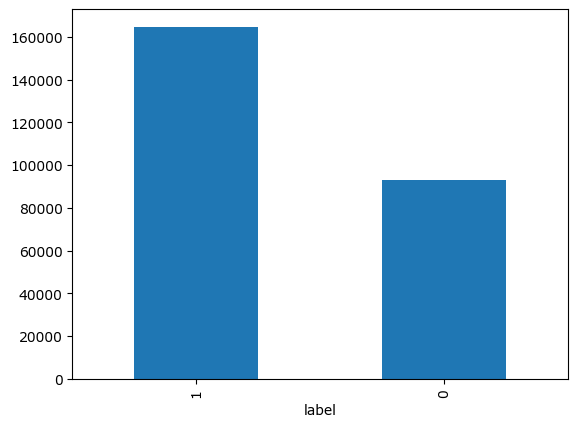

In [18]:
# 'label' sütunundaki sınıf dağılımını çubuk grafik ile görselleştirme
df["label"].value_counts().plot.bar()

In [19]:
# 'label' sütunundaki sınıf oranlarını hesaplama
df["label"].value_counts(normalize=True)

label
1    0.639077
0    0.360923
Name: proportion, dtype: float64

In [20]:
# Analiz ve modelleme için gereksiz sütunları veri setinden çıkarma
# 'id' sütunu yalnızca sıra numarası, 'attack_cat' sütunu ise etiketi içerdiğinden çıkarıldı
df = df.drop(columns=["id", "attack_cat"])

In [21]:
# Kategorik sütunları seçme
df_cat = df.select_dtypes(exclude=[np.number])  
print(df_cat.columns)  # Kategorik sütun isimlerini ekrana yazdırma

# Kategorik sütunları sayısal değerlere dönüştürme (Label Encoding)
for feature in df_cat.columns:
    df[feature] = LabelEncoder().fit_transform(df[feature])

Index(['proto', 'service', 'state'], dtype='object')


In [22]:
df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0.000011,119,0,5,2,0,496,0,90909.0902,254,...,1,1,2,0,0,0,1,2,0,0
1,0.000008,119,0,5,2,0,1762,0,125000.0003,254,...,1,1,2,0,0,0,1,2,0,0
2,0.000005,119,0,5,2,0,1068,0,200000.0051,254,...,1,1,3,0,0,0,1,3,0,0
3,0.000006,119,0,5,2,0,900,0,166666.6608,254,...,2,1,3,0,0,0,2,3,0,0
4,0.000010,119,0,5,2,0,2126,0,100000.0025,254,...,2,1,3,0,0,0,2,3,0,0


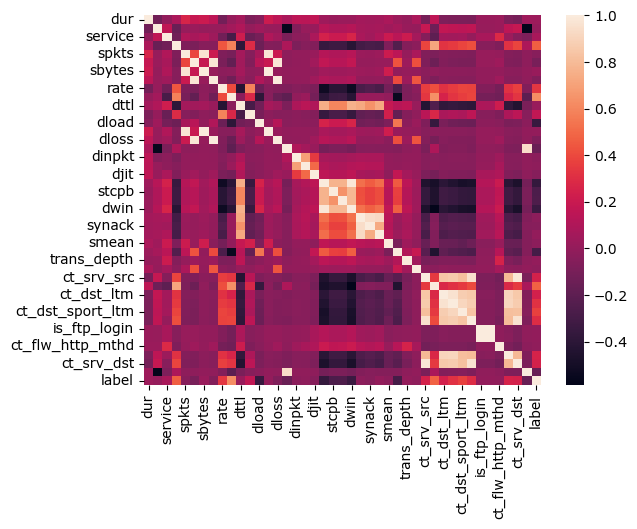

In [23]:
# Veri sütunları arasındaki korelasyonu görselleştirme
# Yüksek derecede ilişkili (korelasyonu yüksek) özellikler modelde gereksiz ağırlık oluşturabileceğinden ileride kaldırılabilir
sns.heatmap(df.corr())
plt.show()

In [24]:
# Sütunlar arasındaki yüksek korelasyonları tespit etme (0.98 üzeri)
columns = df.columns.tolist()
corr = df.corr()
correlated_vars = []

for i in range(len(columns)-1):
    for j in range(i+1, len(columns)):
        if corr[columns[i]][columns[j]] > 0.98:
            print(columns[i], columns[j], corr[columns[i]][columns[j]])
            correlated_vars.append(columns[j])

sbytes sloss 0.995771577240686
dbytes dloss 0.9967111338314709
swin dwin 0.9804584289136614
is_ftp_login ct_ftp_cmd 0.9988554882935945


Yapılan kontrol sonucunda bazı sütunların neredeyse tamamen aynı bilgiyi içerdiği görülmüştür. Örneğin, gönderilen byte sayısı ile kaybolan paket sayısı, alınan byte ile kaybolan paket sayısı gibi çiftler birbirine çok benzemektedir. Benzer şekilde, belirli bağlantı parametreleri ve FTP komutları da birbirine oldukça yakındır. Bu durum, veri setinde bazı sütunların gereksiz tekrar içerdiğini ve bu sütunların çıkarılmasının modelin daha hızlı çalışmasını ve gereksiz karmaşıklığı azaltmasını sağlayabileceğini göstermektedir.

In [25]:
# Yüksek oranda birbirine benzeyen sütunları veri setinden çıkarma
df = df.drop(columns=correlated_vars)

In [26]:
# Özellikler ve hedef değişkenin belirlenmesi
X = df.drop(columns=["label"])         # Modelin öğrenmesi için kullanılacak sütunlar
feature_list = list(X.columns)         # Özellik isimlerini listeleme
X = np.array(X)                        # Veriyi sayısal dizi hâline getirme
y = df["label"]                        # Hedef değişken

# Veri setini eğitim ve test olarak ayırma (%70 eğitim, %30 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [27]:
# Eğitim ve test veri setlerinin büyüklüğünü ekrana yazdırma
print("Training set:", len(X_train))
print("Testing set:", len(X_test))

Training set: 180371
Testing set: 77302


In [28]:
# Tüm özellikleri aynı ölçeğe getirmek için StandardScaler kullanma
scaler = StandardScaler().fit(X_train)  # Eğitim verisine göre ölçekleme parametrelerini öğrenme
X_train = scaler.transform(X_train)    # Eğitim verisini ölçekleme
X_test = scaler.transform(X_test)      # Test verisini aynı ölçekle dönüştürme

In [29]:
# Kullanılacak makine öğrenmesi modellerini sözlük içinde tanımlama
models = {}
models["Decision Tree Classifier"] = DecisionTreeClassifier()   # Karar ağacı
models["Random Forest Classifier"] = RandomForestClassifier()   # Rastgele orman
models["Gaussian Naive Bayes"] = GaussianNB()                   # Gauss Naive Bayes

In [30]:
# Modelleri eğitme ve performans metriklerini hesaplama
train_score, accuracy, precision, recall, training_time, y_pred = {}, {}, {}, {}, {}, {}

for key in models.keys():
    start_time = time.time()                  # Eğitime başlama zamanı
    models[key].fit(X_train, y_train)         # Modeli eğitim verisiyle eğitme
    training_time[key] = time.time() - start_time  # Eğitimin süresini hesaplama
    
    y_pred[key] = models[key].predict(X_test)      # Test verisi ile tahmin yapma
    
    train_score[key] = models[key].score(X_train, y_train)  # Eğitim doğruluğu
    accuracy[key] = models[key].score(X_test, y_test)        # Test doğruluğu
    precision[key] = precision_score(y_test, y_pred[key])   # Hassasiyet
    recall[key] = recall_score(y_test, y_pred[key])         # Duyarlılık

In [31]:
# Özyinelemeli Özellik Eliminasyonu (RFE) ile en etkili özellikleri belirleme
# Başlangıçta tüm özelliklerle başlar, her adımda en az katkı sağlayan özellikleri çıkarır
rfc_rfe = 'Random Forest Classifier + Recursive Feature Elimination'
models[rfc_rfe] = RandomForestClassifier()          # Modeli tanımlama
rfe = RFE(models[rfc_rfe])                         # RFE nesnesini oluşturma

start_time = time.time()
rfe.fit(X_train, y_train)                          # Eğitim verisi ile öznitelik seçimi
training_time[rfc_rfe] = time.time() - start_time  # RFE süresini kaydetme

# Seçilen özelliklerle eğitim ve test verilerini dönüştürme
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Modeli seçilen özniteliklerle eğitme ve tahmin yapma
start_time = time.time()
models[rfc_rfe].fit(X_train_rfe, y_train)
training_time[rfc_rfe] += time.time() - start_time

y_pred[key] = models[rfc_rfe].predict(X_test_rfe)                   # Tahminler
train_score[rfc_rfe] = models[rfc_rfe].score(X_train_rfe, y_train)  # Eğitim doğruluğu
accuracy[rfc_rfe] = models[rfc_rfe].score(X_test_rfe, y_test)       # Test doğruluğu
precision[rfc_rfe] = precision_score(y_test, y_pred[key])           # Hassasiyet
recall[rfc_rfe] = recall_score(y_test, y_pred[key])                 # Duyarlılık

In [32]:
# Öznitelik seçimi öncesi ve sonrası özellik sayısını ekrana yazdırma
print("Eski özelliklerin sayısı:", X.shape[1])                        # Başlangıçtaki toplam sütun sayısı
print("Yeni özelliklerin sayısı:", len(rfe.estimator_.feature_importances_))  # RFE sonrası seçilen sütun sayısı

Eski özelliklerin sayısı: 38
Yeni özelliklerin sayısı: 19


In [33]:
# Modellerin tüm performans metriklerini tek bir tabloya toplama
# Bu tablo sayesinde modellerin eğitim doğruluğu, test doğruluğu,
# hassasiyet, duyarlılık ve eğitim süreleri kolayca karşılaştırılabilir
df_models = pd.DataFrame(index=models.keys(), columns=["Training score","Accuracy","Precision","Recall","Training time"])

df_models["Training score"] = train_score.values()   # Eğitim doğruluğu
df_models["Accuracy"] = accuracy.values()            # Test doğruluğu
df_models["Precision"] = precision.values()         # Hassasiyet
df_models["Recall"] = recall.values()               # Duyarlılık
df_models["Training time"] = training_time.values() # Eğitim süresi

In [34]:
df_models

,Training score,Accuracy,Precision,Recall,Training time
Decision Tree Classifier,0.997732,0.936780,0.951376,0.949624,6.349854
Random Forest Classifier,0.997721,0.949937,0.962277,0.959278,66.342875
Gaussian Naive Bayes,0.833992,0.834558,0.841092,0.913799,0.489884
Random Forest Classifier + Recursive Feature Elimination,0.995105,0.947129,0.959003,0.958246,1223.229837


Tablo incelendiğinde, farklı sınıflandırma algoritmalarının performansları açıkça görülmektedir. Karar ağacı ve rastgele orman modelleri yüksek eğitim ve test doğrulukları ile dengeli sonuçlar sunarken, Gaussian Naive Bayes daha düşük performans göstermiştir. Özellikle rastgele orman ile özyinelemeli özellik eliminasyonu (RFE) uygulandığında, doğruluk ve hassasiyet yüksek kalmasına rağmen eğitim süresi belirgin şekilde artmıştır. Bu durum, öznitelik seçiminin model performansını korurken hesaplama maliyetini yükseltebileceğini göstermektedir. Genel olarak, rastgele orman tabanlı modeller dengeli ve güvenilir bir çözüm sağlamaktadır.